In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from matplotlib import colormaps
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import  spearmanr

In [17]:
path_to_lesions_features_train = Path.cwd() / "resources" / "lesions_features_train.csv"
path_to_lesions_features_test = Path.cwd() / "resources" / "lesions_features_test.csv"
savefig = False
save_title = False

In [3]:
plt.rcParams.update({'font.size': 10})
pd.set_option("display.max_columns", None)

In [4]:
lesions_df = pd.DataFrame()
for subset, path in [('train', path_to_lesions_features_train), ('test', path_to_lesions_features_test)]:
    df = pd.read_csv(path)
    df['subset'] = subset
    lesions_df = pd.concat([lesions_df, df])
lesions_df.reset_index(inplace=True)
lesions_df['lesion_location'] = lesions_df['label_description'].apply(lambda x: x.split(',')[1])
display(lesions_df)

,index,filename,label_value,label_description,voxels_count,volume_ml,slices_count,mean_HU,std_HU,major_axis,minor_axis,major_axis_slice_idx,subset,lesion_location
0,0,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,1,"m,lung",4063,1.303476,14,-31.813192,205.90396,17.447781,11.192733,29,train,lung
1,1,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,3,"m,lung",770,0.247028,7,-56.867530,210.93439,8.931391,6.978943,44,train,lung
2,2,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,4,"m,lung",360,0.115494,4,-132.572220,200.86247,8.486781,5.813380,55,train,lung
3,3,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,5,"m,lung",888,0.284885,7,-141.555180,220.29218,10.068300,7.662258,57,train,lung
4,4,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,6,"m,lung",831,0.266598,7,-87.400720,218.33633,10.531821,5.304151,68,train,lung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,367,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,10,"m,lung",1780,0.708411,11,-178.867980,243.65215,12.507521,10.257025,213,test,lung
944,368,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,11,"m,lung",2136,0.850093,14,-46.566010,170.09471,13.505589,10.146579,263,test,lung
945,369,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,12,"m,lung",1100,0.437782,8,-76.380000,173.26200,13.229759,6.897603,268,test,lung
946,370,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,13,"m,lung",765,0.304457,8,-62.611763,190.63866,9.921417,8.223937,279,test,lung


In [5]:
# For scatterplots
lesions_df['scatterplot_category'] = lesions_df['label_description'].apply(lambda x: 'adenopathy' if x.split(',')[0] == 'n' else x.split(',')[1])
lesions_df['diameter_length'] = lesions_df.apply(lambda x: x['minor_axis'] if x['label_description'].split(',')[0] == 'n' else x['major_axis'], axis=1)

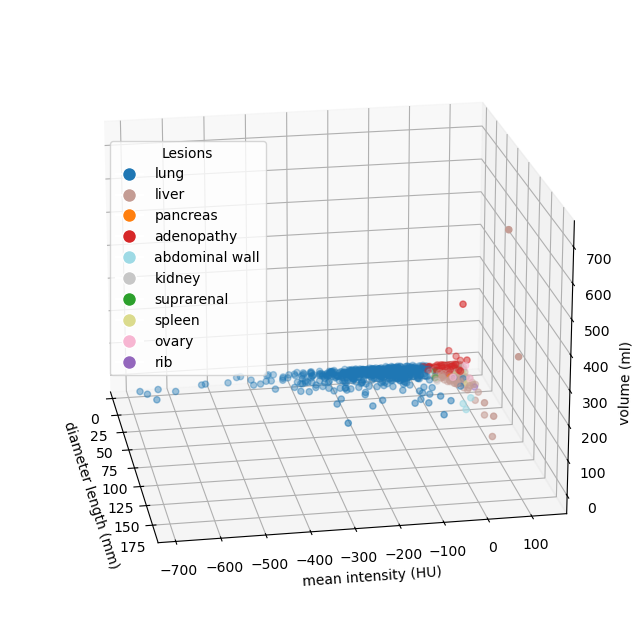

In [6]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps['tab20']
unique_labels = lesions_df['scatterplot_category'].unique().tolist()

# Plot the scatter, with color mapping
colors = [
    cmap(idx / (len(unique_labels) - 1))
    for idx in range(len(unique_labels))
]
random.seed(80) # 6, 9, 13, 40, 60, 80
random.shuffle(colors)
first_color = colors.pop(0)
colors.insert(1, first_color)
color_mapping = {
    key: colors[idx]
    for idx, key in enumerate(unique_labels)
}
lesions_df['color_code'] = lesions_df['scatterplot_category'].apply(lambda x: color_mapping[x])
sc = ax.scatter(
    lesions_df['diameter_length'],
    lesions_df['mean_HU'],
    lesions_df['volume_ml'],
    c=lesions_df['color_code']
)

# Labels for axes
ax.set_xlabel('diameter length (mm)')
ax.set_ylabel('mean intensity (HU)')
ax.set_zlabel('volume (ml)')

# add legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10, label=label)
                  for label in unique_labels]
ax.legend(handles=legend_patches, title="Lesions",  loc='upper left', bbox_to_anchor=(0.15, 0.8))

# Show plot
ax.view_init(elev=20, azim=-10)
#plt.tight_layout()
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'scatterplot_3d.png', transparent=True, bbox_inches='tight')
plt.show()

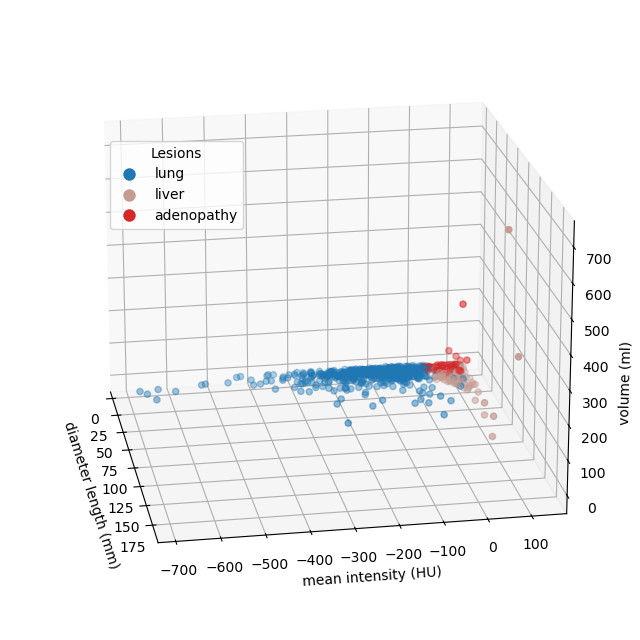

In [7]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111, projection='3d')  # This implicitly uses Axes3D
cmap = colormaps['tab20']

lesions_df_subset = lesions_df[lesions_df['scatterplot_category'].isin(['lung', 'liver', 'adenopathy'])].copy()
unique_labels = lesions_df_subset['scatterplot_category'].unique().tolist()

# Plot the scatter, with color mapping
color_mapping = {
    key: color
    for key, color in color_mapping.items()
    if key in unique_labels
}
lesions_df_subset['color_code'] = lesions_df_subset['scatterplot_category'].apply(lambda x: color_mapping[x])
sc = ax.scatter(
    lesions_df_subset['diameter_length'],
    lesions_df_subset['mean_HU'],
    lesions_df_subset['volume_ml'],
    c=lesions_df_subset['color_code']
)

# Labels for axes
ax.set_xlabel('diameter length (mm)')
ax.set_ylabel('mean intensity (HU)')
ax.set_zlabel('volume (ml)')

# add legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10, label=label)
                  for label in unique_labels]
ax.legend(handles=legend_patches, title="Lesions", loc='upper left', bbox_to_anchor=(0.15, 0.8))

# Show plot
ax.view_init(elev=20, azim=-10) #azim:-60, -260, 270
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'scatterplot_3d_lung_liver_adenopathy.png', transparent=True, bbox_inches='tight')
plt.show()

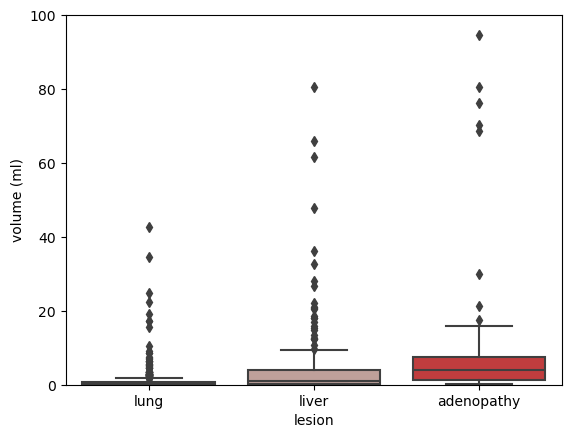

Volume (ml) stats all lesions
------------------------------


count    948.000000
mean       5.287330
std       31.633237
min        0.014906
25%        0.190782
50%        0.479226
75%        1.567453
max      719.045727
Name: volume_ml, dtype: float64



Volume (ml) stats of subset
------------------------------


,count,mean,std,min,25%,50%,75%,max
scatterplot_category,,,,,,,,
adenopathy,83.0,17.698524,45.985041,0.146850,1.250587,3.963807,7.539530,335.943453
liver,179.0,12.610798,62.558273,0.098063,0.322206,1.099184,4.015309,719.045727
lung,664.0,1.034950,3.015528,0.014906,0.125941,0.347775,0.800435,42.737846


In [8]:
# Lesion volumes
sns.boxplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='volume_ml',
    palette=color_mapping
)
plt.ylim((0, 100))
plt.xlabel('lesion')
plt.ylabel('volume (ml)')
plt.title('Boxplot of Lesions Volumes')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_volumes_distributions.png', bbox_inches='tight', transparent=True)
plt.show()
print(f"Volume (ml) stats all lesions")
print(30 * '-')
display(lesions_df['volume_ml'].describe())
print('\n')
print(f"Volume (ml) stats of subset")
print(30 * '-')
display(lesions_df_subset.groupby('scatterplot_category')['volume_ml'].describe())

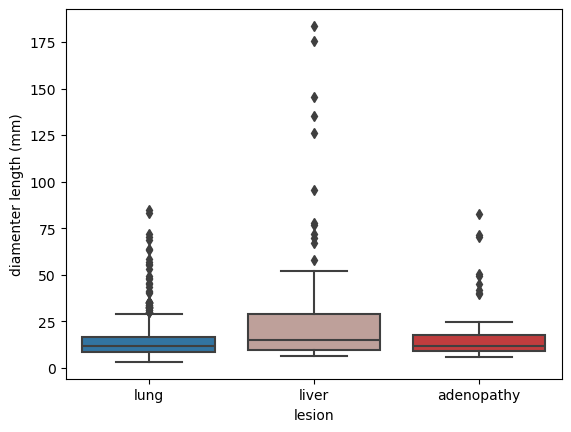

Diameter length (mm) stats all lesions
------------------------------


count    948.000000
mean      17.064612
std       16.603570
min        3.239035
25%        8.709545
50%       12.150826
75%       19.018821
max      183.614494
Name: diameter_length, dtype: float64



Diameter length (mm) stats of subset
------------------------------


,count,mean,std,min,25%,50%,75%,max
scatterplot_category,,,,,,,,
adenopathy,83.0,17.068770,14.717016,5.717789,8.849850,11.827819,17.667490,82.463946
liver,179.0,24.104009,26.994150,6.155379,9.773815,14.775184,28.833085,183.614494
lung,664.0,14.361444,10.349882,3.239035,8.319755,11.530477,16.819744,84.770690


In [9]:
# Lesions diameters
sns.boxplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='diameter_length',
    palette=color_mapping
)
plt.xlabel('lesion')
plt.ylabel('diamenter length (mm)')
plt.title('Boxplot of Lesions Diameter Lengths')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_diameter_lengths_distributions.png', bbox_inches='tight', transparent=True)
plt.show()
print(f"Diameter length (mm) stats all lesions")
print(30 * '-')
display(lesions_df['diameter_length'].describe())
print('\n')
print(f"Diameter length (mm) stats of subset")
print(30 * '-')
display(lesions_df_subset.groupby('scatterplot_category')['diameter_length'].describe())

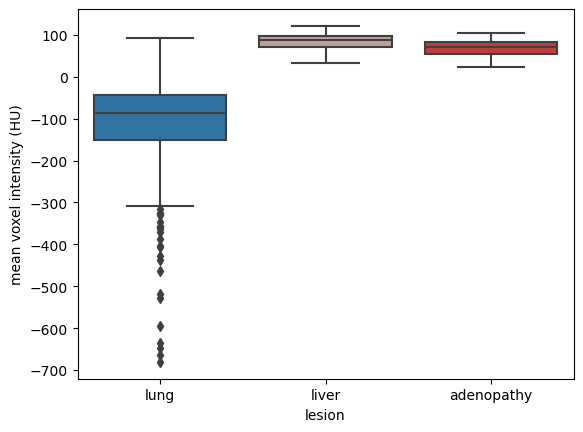

Mean voxel intensity (HU) stats all lesions
------------------------------


count    948.000000
mean     -51.759996
std      120.622064
min     -680.534400
25%     -119.533261
50%      -49.330497
75%       57.178452
max      121.464290
Name: mean_HU, dtype: float64



Mean voxel intensity (HU) stats of subset
------------------------------


,count,mean,std,min,25%,50%,75%,max
scatterplot_category,,,,,,,,
adenopathy,83.0,67.650898,19.736214,23.533583,55.089325,70.083336,82.056305,104.203514
liver,179.0,85.185032,19.571526,33.061710,72.110030,87.586620,98.523798,121.464290
lung,664.0,-107.723983,100.539634,-680.534400,-152.016435,-86.594071,-44.277491,92.454740


In [10]:
# Lesions intensiteis (mean HU)
sns.boxplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='mean_HU',
    palette=color_mapping
)
plt.xlabel('lesion')
plt.ylabel('mean voxel intensity (HU)')
plt.title('Boxplot of Lesions Mean Voxel Intensities')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_mean_HU_boxplots.png', bbox_inches='tight', transparent=True)
plt.show()
print(f"Mean voxel intensity (HU) stats all lesions")
print(30 * '-')
display(lesions_df['mean_HU'].describe())
print('\n')
print(f"Mean voxel intensity (HU) stats of subset")
print(30 * '-')
display(lesions_df_subset.groupby('scatterplot_category')['mean_HU'].describe())

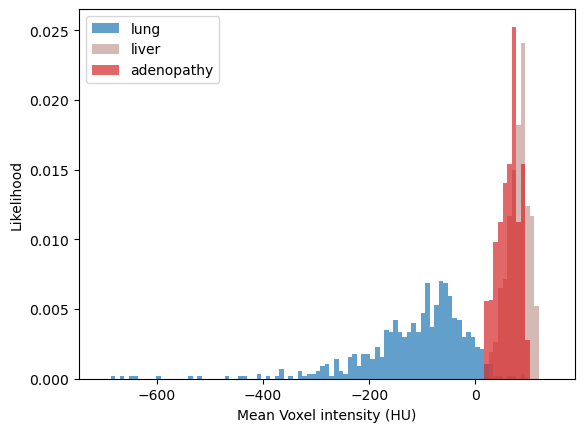

In [11]:
min_value = -700
max_value = 150
bins = 100
bin_edges = np.linspace(min_value, max_value, bins)
for category in unique_labels:
    hist_values, _ = np.histogram(
        lesions_df_subset[lesions_df_subset['scatterplot_category'] == category]['mean_HU'],
        bins=bin_edges,
        density=True
    )
    plt.bar(
        bin_edges[:-1],
        hist_values,
        width=np.diff(bin_edges),
        alpha=0.7,
        label=category,
        color=color_mapping[category]
    )
plt.xlabel('Mean Voxel intensity (HU)')
plt.ylabel('Likelihood')
plt.title('Distribution of Mean Voxel Intensities of Lesions')
plt.legend()
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_mean_HU_distributions.png', bbox_inches='tight', transparent=True)
plt.show()    

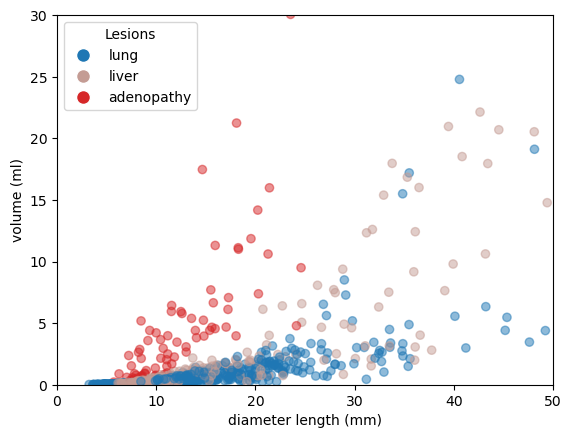

In [12]:
# Scatterplot of diameter length versus volume
_, ax = plt.subplots()
ax.scatter(
    lesions_df_subset['diameter_length'],
    lesions_df_subset['volume_ml'],
    alpha=0.5,
    c=lesions_df_subset['color_code']
)
#plt.xlim((0, 75))
#plt.ylim((0, 200))
plt.xlim((0, 50))
plt.ylim((0, 30))
plt.xlabel('diameter length (mm)')
plt.ylabel('volume (ml)')
plt.title("Scatterplot of Lesions in terms of Diameter Length and Volume")
# add legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10, label=label)
                  for label in unique_labels]
ax.legend(handles=legend_patches, title="Lesions", loc='upper left')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'scatterplot_diameter_length_vs_volume.png', bbox_inches='tight', transparent=True)
plt.show()

In [13]:
# Spearman test (all lesions)
correlation, p_value = spearmanr(lesions_df["diameter_length"], lesions_df["volume_ml"])
print("Spearman test for all lesions")
print(30 * '-')
print(f"Spearman correlation: {correlation:.3f}")
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant monotonic relationship between diameter and volume.")
else:
    print("There is no statistically significant monotonic relationship.")

# Spearman test (subset)
for category in unique_labels:
    correlation, p_value = spearmanr(
        lesions_df_subset[lesions_df_subset['scatterplot_category'] == category]["diameter_length"],
        lesions_df_subset[lesions_df_subset['scatterplot_category'] == category]["volume_ml"]
    )
    print('\n')
    print(f"Spearman test for {category}")
    print(30 * '-')
    print(f"Spearman correlation: {correlation:.3f}")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("There is a statistically significant monotonic relationship between diameter and volume.")
    else:
        print("There is no statistically significant monotonic relationship.")


Spearman test for all lesions
------------------------------
Spearman correlation: 0.874
p-value: 6.768620787825519e-299
There is a statistically significant monotonic relationship between diameter and volume.


Spearman test for lung
------------------------------
Spearman correlation: 0.931
p-value: 1.060844678158454e-292
There is a statistically significant monotonic relationship between diameter and volume.


Spearman test for liver
------------------------------
Spearman correlation: 0.942
p-value: 1.1178582803421065e-85
There is a statistically significant monotonic relationship between diameter and volume.


Spearman test for adenopathy
------------------------------
Spearman correlation: 0.894
p-value: 5.783763146832461e-30
There is a statistically significant monotonic relationship between diameter and volume.


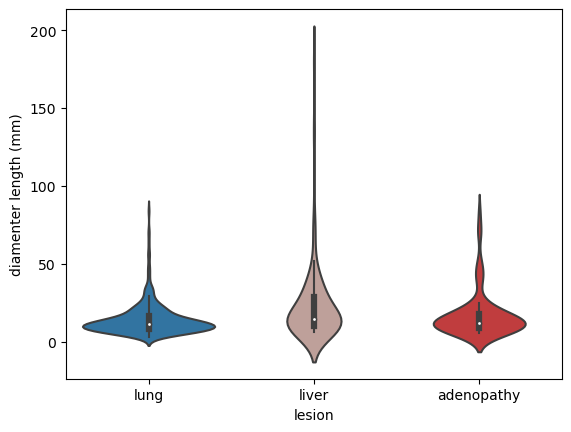

In [14]:
# Violin plots: diameter length
sns.violinplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='diameter_length',
    palette=color_mapping
)
plt.xlabel('lesion')
plt.ylabel('diamenter length (mm)')
plt.title('Distribution of Lesions Diameter Length')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'violins_diameter_length.png', bbox_inches='tight', transparent=True)
plt.show()

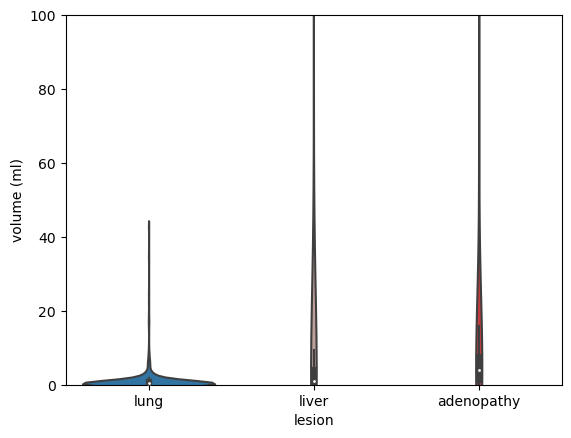

In [15]:
# Violin plots: volume
sns.violinplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='volume_ml',
    palette=color_mapping
)
plt.xlabel('lesion')
plt.ylabel('volume (ml)')
plt.title('Distribution of Lesions Volume')
plt.ylim((0, 100))
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'violins_volume.png', bbox_inches='tight', transparent=True)
plt.show()

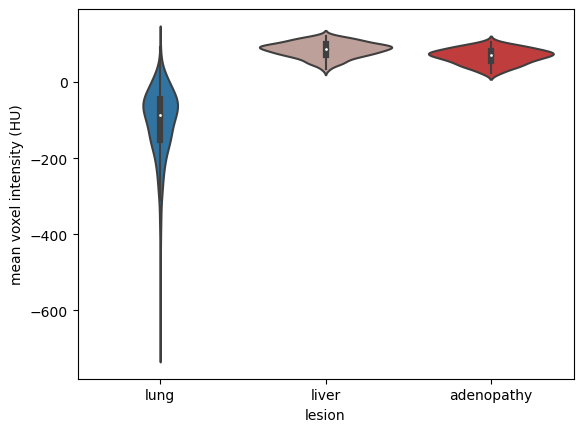

In [16]:
# Violin plots: mean voxel intensity
sns.violinplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='mean_HU',
    palette=color_mapping
)
plt.xlabel('lesion')
plt.ylabel('mean voxel intensity (HU)')
plt.title('Distribution of Lesions Mean Voxel Intensity')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'violins_mean_HU.png', bbox_inches='tight', transparent=True)
plt.show()